In [1]:
import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Flickr
from torch_geometric import nn

import numpy as np
import random

import matplotlib.pyplot as plt

from hgt import HGT
from heteroGNN import HeteroGNN
import graph_polluters
from tqdm import tqdm

# We initialize conference node features with a single one-vector as feature:
dataset = Flickr('./data/flikr')
data = dataset[0]
print(data)


def set_seed(seed=42):
    #torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    #torch.use_deterministic_algorithms(True)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)

Data(x=[89250, 500], edge_index=[2, 899756], y=[89250], train_mask=[89250], val_mask=[89250], test_mask=[89250])


In [2]:
data.y.min()

tensor(0)

# Model
Here we define our model and Training Loop

In [3]:
# %%
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def init_parameters(data):
    model = nn.GAT(in_channels=(-1,-1), hidden_channels=10, num_layers=4, out_channels=7, dropout=0.5)
    #model = HGT(hidden_channels=64, out_channels=4, num_heads=2, num_layers=3, data=data)
    data, model = data.to(device), model.to(device)
    with torch.no_grad():  # Initialize lazy modules.
        out = model(data.x, data.edge_index)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
    return model, optimizer

# %%
def train(data, model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    mask = data.train_mask
    loss = F.cross_entropy(out[mask], data.y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data, model):
    model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data[split]
        acc = (pred[mask] == data.y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs

# Tests
We see how the model copes with the various pollution in the graph

## Baseline

In [5]:
set_seed()
dataset_copy = dataset.copy()
data_copy = dataset_copy[0]
data_copy.to(device)
model, optimizer = init_parameters(data_copy)
train_accs, val_accs, test_accs = [],[],[]
for epoch in range(5000):
    loss = train(data=data_copy, model=model, optimizer=optimizer)
    train_acc, val_acc, test_acc = test(data = data_copy, model=model)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
print(f'Baseline, Train: {train_acc:.4f}, '
        f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Baseline, Train: 0.5203, Val: 0.5177, Test: 0.5148


## Remove Features

50% dirty, Train: 1.0000, Val: 0.7150, Test: 0.7283


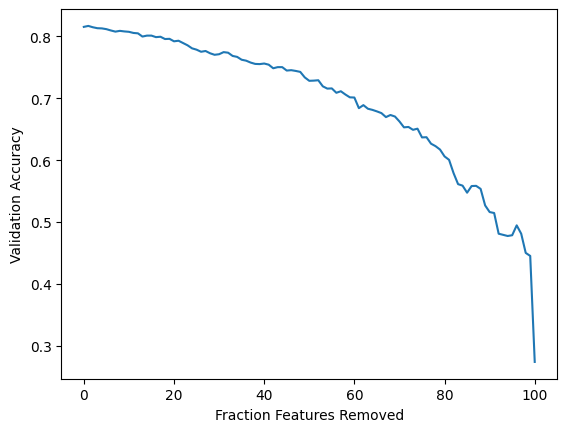

In [5]:
print_precentages = [50]

test_acc_hist = []
for percent in range(101):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    graph_polluters.remove_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(101), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features Removed')
plt.show()

50% dirty, Train: 1.0000, Val: 0.7475, Test: 0.7470


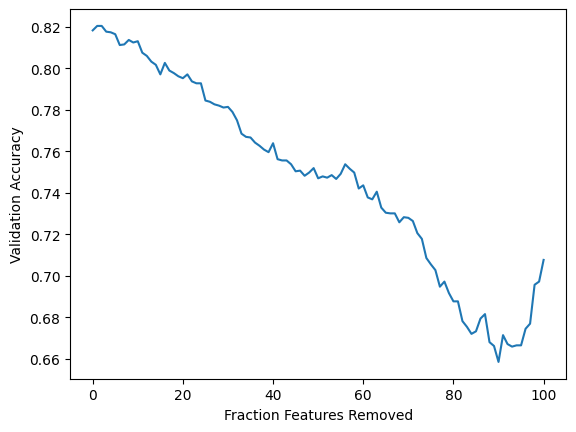

In [10]:
print_precentages = [50]

test_acc_hist = []
for percent in range(101):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    graph_polluters.remove_features(data=data_copy, probability=pollution_probability, node_types=['author', 'paper'])
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(101), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features Removed')
plt.show()

## Randomize Features

 51%|█████     | 51/100 [02:19<02:14,  2.74s/it]

50% dirty, Train: 1.0000, Val: 0.6075, Test: 0.6322


100%|██████████| 100/100 [04:33<00:00,  2.74s/it]


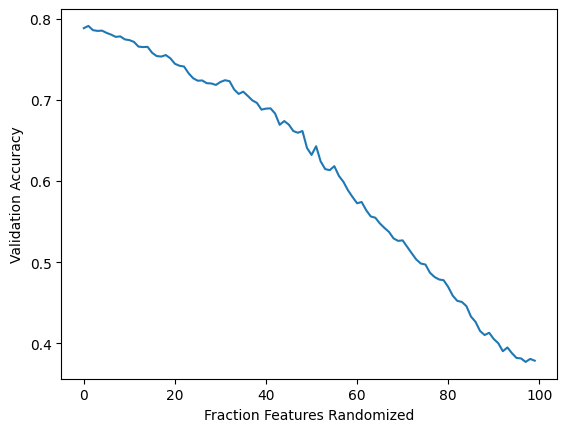

In [6]:
print_precentages = [50]
test_acc_hist = []
for percent in tqdm(range(100)):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    graph_polluters.randomize_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(100), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features Randomized')
plt.show()

 51%|█████     | 51/100 [02:19<02:14,  2.74s/it]

50% dirty, Train: 1.0000, Val: 0.6075, Test: 0.6322


100%|██████████| 100/100 [04:34<00:00,  2.74s/it]


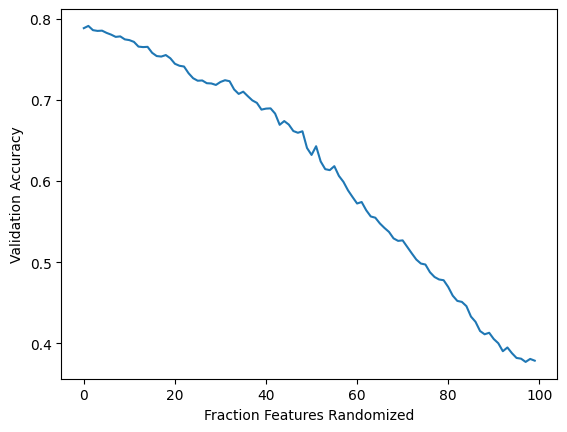

In [7]:
print_precentages = [50]
test_acc_hist = []
for percent in tqdm(range(100)):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    graph_polluters.randomize_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(100), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features Randomized')
plt.show()

## Remove Edges

 51%|█████     | 51/100 [01:35<01:14,  1.52s/it]

50% dirty, Train: 0.9975, Val: 0.7525, Test: 0.7660


100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


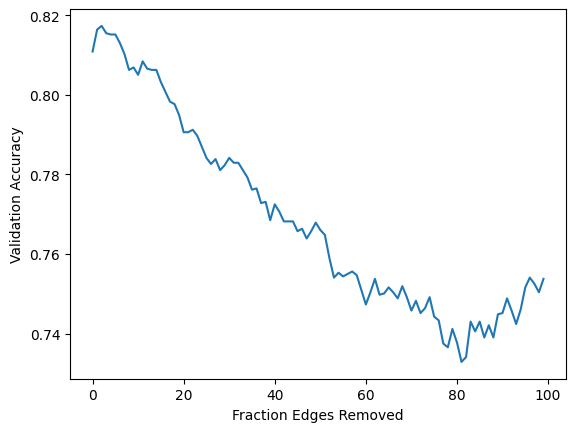

In [8]:
print_precentages = [50]
test_acc_hist = []
for percent in tqdm(range(100)):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    data_copy = graph_polluters.remove_edges(data_copy, pollution_probability)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(100), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Edges Removed')
plt.show()

 51%|█████     | 51/100 [01:52<01:31,  1.87s/it]

50% dirty, Train: 0.9850, Val: 0.5525, Test: 0.5913


100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


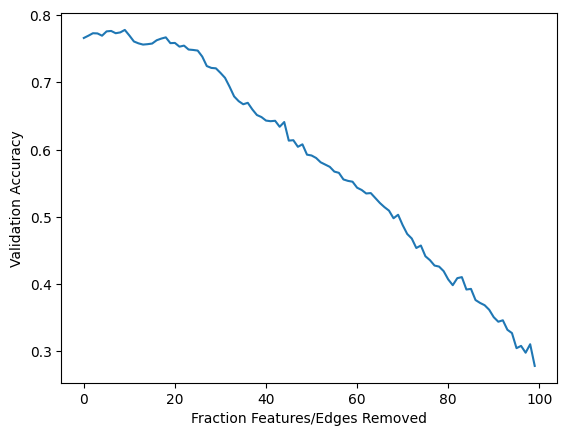

In [9]:
print_precentages = [50]
test_acc_hist = []
for percent in tqdm(range(100)):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    data_copy = graph_polluters.remove_edges(data_copy, pollution_probability)
    graph_polluters.remove_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(100), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features/Edges Removed')
plt.show()